In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
data=pd.read_csv("crypto_data.csv")

In [17]:
data['market'] = data['c'] * data['v']
import numpy as np 
# close -> log_close
data['volatilite'] = data['h'] - data['l']
# market -> log_market
#crypto['log_market'] = np.log(crypto.market)
data['log_market'] = np.log(data.market)
data['rolling_mean_24h'] = data['c'].rolling(window=24, min_periods=1).mean()
data['rolling_std_24h'] = data['c'].rolling(window=24, min_periods=1).std()

# Spread
data['spread'] = (data.h - data.l) / data.c
# return -> log (close / open)
data['log_return'] = np.log(data.c / data.c.shift(1))

data.dropna(inplace=True)


In [18]:
data.head()

,symbol,t,o,h,l,c,v,vw,n,market,volatilite,log_market,rolling_mean_24h,rolling_std_24h,spread,log_return
12,BTC/USD,2024-08-01T12:00:00Z,64608.8740,64880.8130,64608.8740,64850.1510,0.007167,64848.569204,3,464.791538,271.9390,6.141589,64744.823250,148.955933,0.004193,0.003254
13,BTC/USD,2024-08-01T13:00:00Z,64864.3055,64932.4700,64455.2620,64739.3350,0.206658,64750.915359,4,13378.930496,477.2080,9.501436,64742.993833,105.375401,0.007371,-0.001710
14,BTC/USD,2024-08-01T14:00:00Z,64686.7775,64726.4065,63933.2985,63933.2985,0.120960,64444.103306,11,7733.389816,793.1080,8.953303,64540.570000,413.889216,0.012405,-0.012529
15,BTC/USD,2024-08-01T15:00:00Z,63901.4150,63920.0150,62664.4300,62859.5950,0.222437,63159.464767,20,13982.307213,1255.5850,9.545548,64204.375000,832.834679,0.019974,-0.016937
16,BTC/USD,2024-08-01T16:00:00Z,62842.0500,63134.9850,62616.5905,62873.0780,0.089451,62899.731652,15,5624.057940,518.3945,8.634809,63982.492167,922.107820,0.008245,0.000214


c:\Users\User\Desktop\project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


   Model Target           MAE          RMSE      MAPE (%)
0  ARIMA      h  1.082732e-14  7.016904e-14  4.071313e-16


c:\Users\User\Desktop\project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\Desktop\project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


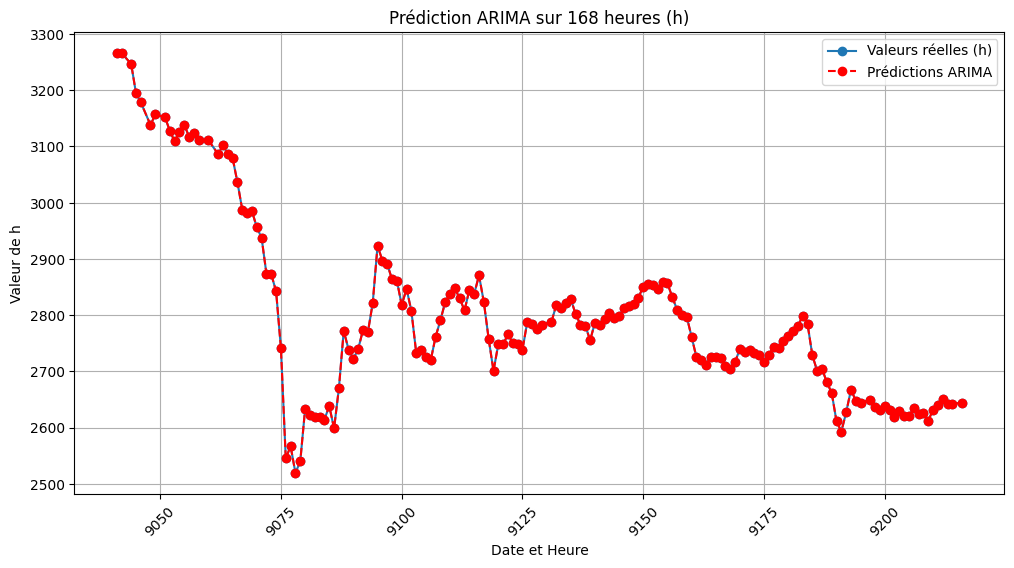

              h  arima_pred
9041  3265.6950   3265.6950
9042  3266.2350   3266.2350
9044  3246.5000   3246.5000
9045  3194.6290   3194.6290
9046  3178.1500   3178.1500
...         ...         ...
9211  2640.0550   2640.0550
9212  2650.6360   2650.6360
9213  2642.4450   2642.4450
9214  2642.6945   2642.6945
9216  2643.4985   2643.4985

[168 rows x 2 columns]


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_exog_vars(target):
    """
    Sélectionne les variables exogènes en fonction de la variable cible.
    
    Paramètre :
    - target : La colonne cible ('c', 'o', etc.)
    
    Retourne :
    - Liste des variables exogènes correspondantes
    """
    features = ['o','c', 'h', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return']
    return [f for f in features if f != target]  # Exclure la target des exogènes


def train_arima(train_data, target='c', order=(2,1,2)):
    """
    Entraîne un modèle ARIMA sur les données fournies.

    Paramètres :
    - train_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour l'entraînement ('c', 'o', etc.).
    - order : Tuple (p,d,q) pour la configuration d'ARIMA.

    Retourne :
    - Le modèle entraîné
    """
    exog_vars = get_exog_vars(target)  # Sélection dynamique des variables exogènes

    arima_model = ARIMA(train_data[target], order=order, exog=train_data[exog_vars])
    arima_fit = arima_model.fit()
    
    return arima_fit


def evaluate_arima(model, test_data, target='c'):
    """
    Évalue un modèle ARIMA en faisant des prédictions et en calculant les métriques.

    Paramètres :
    - model : Modèle ARIMA entraîné.
    - test_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour la prédiction ('c', 'o', etc.).

    Retourne :
    - Un DataFrame avec les valeurs réelles et prédites.
    - Affiche les métriques et un graphique.
    """
    exog_vars = get_exog_vars(target)  # Sélection dynamique des variables exogènes

    # Prédiction sur la période test
    arima_pred = model.forecast(steps=len(test_data), exog=test_data[exog_vars])
    
    # Ajout des prédictions dans le DataFrame test
    test_data = test_data.copy()  # Éviter SettingWithCopyWarning
    test_data['arima_pred'] = arima_pred.values

    # Calcul des métriques d’évaluation
    mae = mean_absolute_error(test_data[target], test_data['arima_pred'])
    rmse = np.sqrt(mean_squared_error(test_data[target], test_data['arima_pred']))
    mape = np.mean(np.abs((test_data[target] - test_data['arima_pred']) / test_data[target])) * 100

    # Affichage des métriques
    metrics_results = pd.DataFrame({
        "Model": ["ARIMA"],
        "Target": [target],
        "MAE": [mae],
        "RMSE": [rmse],
        "MAPE (%)": [mape],
    })

    print(metrics_results)

    # Tracé des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[target], marker='o', linestyle='-', label=f'Valeurs réelles ({target})')
    plt.plot(test_data.index, test_data['arima_pred'], marker='o', linestyle='--', label='Prédictions ARIMA', color='red')

    plt.xlabel("Date et Heure")
    plt.ylabel(f"Valeur de {target}")
    plt.title(f"Prédiction ARIMA sur {len(test_data)} heures ({target})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    return test_data[[target, 'arima_pred']]


# ----------- Utilisation -----------

# Nettoyage des données
data.dropna(inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Définition des périodes d'entraînement et de test en heures
train_hours = 30 * 24  # 30 jours en heures
forecast_hours = 7 * 24  # 7 jours en heures
train = data.iloc[-(train_hours + forecast_hours):-forecast_hours]
test = data.iloc[-forecast_hours:]

# Sélection de la variable cible
target_variable = 'h'  # 'c', 'o', etc.

# Entraînement du modèle
arima_model = train_arima(train, target=target_variable)

# Évaluation et affichage des résultats
results = evaluate_arima(arima_model, test, target=target_variable)
print(results)
